In [59]:
import os
import pandas as pd

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import ipywidgets as widgets
from IPython.display import display, clear_output

class MyPCA:
    def __init__(self, data):
        self.features_list = data.columns
        # Normalisation des données
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data)
        self.data = pd.DataFrame(data_scaled, index=data.index, columns=self.features_list)

        # Application de l'ACP
        self.pca = PCA()
        data_pca = self.pca.fit_transform(data_scaled)
        self.data_pca = pd.DataFrame(data_pca, columns=[f'PC{x}' for x in range(1, data_pca.shape[1]+1)])

    def eigenval_plot(self):
        plt.figure(figsize=(8, 5))
        plt.bar(range(1, len(self.pca.explained_variance_ratio_) + 1), self.pca.explained_variance_ratio_, color='blue', alpha=0.7)
        plt.xlabel("Factors")
        plt.ylabel("Percentage of Inertia")
        plt.title("Eigenvalues histogram")
        plt.xticks(np.arange(1, len(self.pca.explained_variance_ratio_) + 1, step=1))
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

    def var_plot(self):
        # Conteneur d'affichage
        output = widgets.Output()

        # Fonction de mise à jour du graphique
        def update_plot(*_):
            with output:
                clear_output(wait=True)
                pc_x, pc_y = pc_x_widget.value - 1, pc_y_widget.value - 1
                fig, ax = plt.subplots(figsize=(fig_size_widget.value, fig_size_widget.value))

                # Dégradé de couleur selon une colonne spécifique
                color_column = point_color_widget.value
                if color_column is not None:
                    color_values = self.data[color_column]
                    norm = plt.Normalize(color_values.min(), color_values.max())
                else:
                    color_values = None
                    norm = None

                # Ajouter les points colorés en fonction de la valeur dans color_column
                if show_point_widget.value:
                    if color_values is not None:
                        scatter = ax.scatter(
                            self.data_pca.iloc[:, pc_x], self.data_pca.iloc[:, pc_y],
                            c=color_values, cmap='RdBu', norm=norm, edgecolors='k', s=75
                        )
                        cbar = plt.colorbar(scatter, ax=ax, shrink=0.6)  # Réduire la taille de la barre de couleur
                        cbar.ax.tick_params(labelsize=6, width=0.1)
                        cbar.set_label(color_column, fontsize=9)
                    else:
                        ax.scatter(self.data_pca.iloc[:, pc_x], self.data_pca.iloc[:, pc_y], color='blue', edgecolors='k', alpha=0.7, s=75)

                    if show_point_labels_widget.value:
                        for i, txt in enumerate(self.data.index):
                            x, y = self.data_pca.iloc[i, pc_x], self.data_pca.iloc[i, pc_y]
                            ax.text(x, y, txt, fontsize=9, ha='right')

                # Cercle unité
                ax.add_artist(plt.Circle((0, 0), 1, color='gray', linestyle='--', fill=False))

                # Flèches des variables
                correlations = self.pca.components_.T * np.sqrt(self.pca.explained_variance_)
                if show_all_vectors_widget.value:
                    for i in range(correlations.shape[0]):
                        x, y = correlations[i, pc_x], correlations[i, pc_y]
                        # Par défaut, tous les vecteurs sont rouges
                        vector_color = 'red'
                        # Si un vecteur est sélectionné, on le colore en vert
                        if self.features_list[i] == vector_color_widget.value:
                            vector_color = 'green'
                        plt.arrow(0, 0, x, y, color=vector_color, alpha=0.7, head_width=0.04, head_length=0.04)
                        if show_vector_labels_widget.value:
                            plt.text(x, y, self.features_list[i], fontsize=10, ha='center', va='center')

                # Ajustements visuels pour se focaliser sur [-axis_limit, axis_limit]
                ax.set_xlim(-axis_limit_widget.value, axis_limit_widget.value)
                ax.set_ylim(-axis_limit_widget.value, axis_limit_widget.value)
                ax.set_xlabel(f'PC{pc_x + 1}')
                ax.set_ylabel(f'PC{pc_y + 1}')
                ax.set_title('Variable plots (PCA)')
                ax.set_aspect('equal')
                plt.axhline(0, color='grey', linestyle='--')
                plt.axvline(0, color='grey', linestyle='--')
                plt.grid(False)
                plt.show()

        # Widgets pour sélectionner les composantes principales
        pc_x_widget = widgets.IntSlider(value=1, min=1, max=self.pca.n_components_, description='PC X:')
        pc_y_widget = widgets.IntSlider(value=2, min=1, max=self.pca.n_components_, description='PC Y:')

        # Section 1 : Sélection des composantes principales
        pc_selection_label = widgets.Label(value="Principal Components Selection")
        pc_selection = widgets.VBox([pc_selection_label, pc_x_widget, pc_y_widget], layout=widgets.Layout(border='1px solid gray', padding='10px', margin='5px'))

        # Widgets pour les points
        show_point_widget = widgets.Checkbox(value=False, description='Show points')
        show_point_labels_widget = widgets.Checkbox(value=False, description='Show point labels')
        point_color_widget = widgets.Dropdown(
            options=[("None", None)] + [(col, col) for col in self.features_list],
            value=None,
            description='Point color:'
        )

        # Section 2 : Options d'affichage des points
        point_options_label = widgets.Label(value="Point Display Options")
        point_options = widgets.VBox([point_options_label, show_point_widget, show_point_labels_widget, point_color_widget], layout=widgets.Layout(border='1px solid gray', padding='10px', margin='5px'))

        # Widgets pour les vecteurs
        show_all_vectors_widget = widgets.Checkbox(value=True, description='Show vectors')
        show_vector_labels_widget = widgets.Checkbox(value=False, description='Show vector labels')
        vector_color_widget = widgets.Dropdown(
            options=[("None", None)] + [(col, col) for col in self.features_list],
            value=None,
            description='Vector color:'
        )

        # Section 3 : Options d'affichage des vecteurs
        vector_options_label = widgets.Label(value="Vector Display Options")
        vector_options = widgets.VBox([vector_options_label, show_all_vectors_widget, show_vector_labels_widget, vector_color_widget], layout=widgets.Layout(border='1px solid gray', padding='10px', margin='5px'))

        # Widgets pour les paramètres généraux
        fig_size_widget = widgets.IntSlider(value=10, min=8, max=14, description='Figure length')
        axis_limit_widget = widgets.IntSlider(value=2, min=1, max=40, description='Axis limit')

        # Section 4 : Paramètres généraux
        general_options_label = widgets.Label(value="General Settings")
        general_options = widgets.VBox([general_options_label, fig_size_widget, axis_limit_widget], layout=widgets.Layout(border='1px solid gray', padding='10px', margin='5px'))

        # Liaison des widgets
        for widget in [pc_x_widget, pc_y_widget, show_point_widget, show_point_labels_widget, show_all_vectors_widget,
                    show_vector_labels_widget, fig_size_widget, axis_limit_widget, point_color_widget, vector_color_widget]:
            widget.observe(update_plot, names='value')

        # Affichage des sections
        display(widgets.VBox([pc_selection, point_options, vector_options, general_options]), output)
        update_plot()

In [156]:
data = pivot_dataset.T
features_list = data.columns
# Normalisation des données
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data = pd.DataFrame(data_scaled, index=data.index, columns=features_list)

# Application de l'ACP
pca = PCA()
data_pca = pca.fit_transform(data_scaled)
res = pd.DataFrame(
    pca.components_,
    columns=features_list
)

In [161]:
res.loc[[0,1]].T

,0,1
Metrics,,
% Change YTD,-0.133430,0.342638
Assets/Equity,0.243928,0.024041
Dividend Payout,0.277640,0.150398
Dividend Yield,0.193530,0.402876
EBIT Margin,-0.281439,-0.092945
EBITDA Margin,-0.151949,0.011914
EPS NTMA Growth 1 year,0.177536,-0.335756
Enterprise Value to EBIT,0.289626,-0.001844
Enterprise Value to EBITDA,0.289142,-0.044327


In [141]:
df = pd.read_csv(os.getcwd()+"/Dataset_Clean.csv", index_col="Metrics")
df.columns

Index(['Date', 'Energy', 'Utilities', 'Materials', 'Financials', 'Industrials',
       'Health Care', 'Real Estate', 'Consumer Staples'],
      dtype='object')

In [142]:
sector = 'Energy'

dataset = df[[sector, 'Date']]
pivot_dataset = dataset.reset_index().pivot(index='Metrics', columns='Date')
pivot_dataset = pivot_dataset.dropna()
pivot_dataset = pivot_dataset[sector]

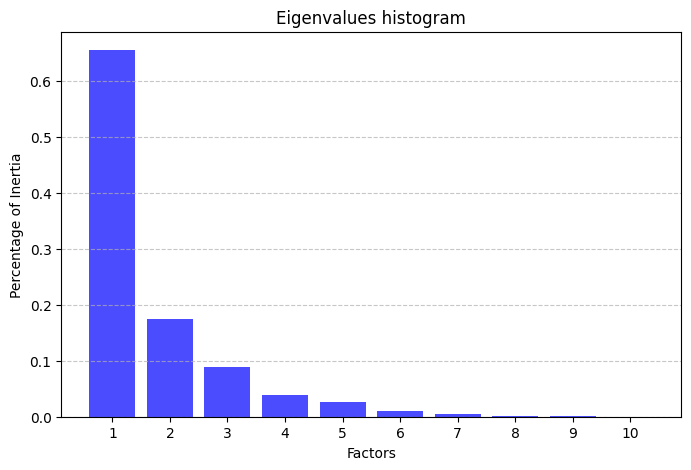

In [143]:
MyPCA(pivot_dataset.T).eigenval_plot()

In [144]:
MyPCA(pivot_dataset.T).var_plot()

Output()